In [1]:
import sys

sys.version

'3.5.2 (default, Oct  8 2019, 13:06:37) \n[GCC 5.4.0 20160609]'

In [2]:
import numpy as np
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'
import tensorflow as tf
# from tensorflow.compat.v1 import InteractiveSession
# config = tf.compat.v1.ConfigProto()
# config.gpu_options.allow_growth = True
# sess = tf.compat.v1.Session(config=config)
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Activation
from keras.layers import Dense, Flatten
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import *
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

/home/dhanashree/MyFolder/Dev/video_classification/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/dhanashree/MyFolder/Dev/video_classification/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/dhanashree/MyFolder/Dev/video_classification/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)]

In [3]:
import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True

In [4]:
tf_config = tf.compat.v1.ConfigProto()
sess = tf.compat.v1.Session(config=tf_config)
graph = tf.compat.v1.get_default_graph()

In [5]:
sess = tf.compat.v1.Session(config=config)
tf.keras.backend.set_session(tf.Session(config=config))

In [6]:
keras.__version__

'2.3.1'

In [7]:
# Just disables the warning, doesn't enable AVX/FMA
import tensorflow as tf
import os
tf.__version__
#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

'1.13.1'

In [8]:
tf.test.is_gpu_available()

False

In [9]:
%pwd

'/home/dhanashree/MyFolder/Dev/atoz/digits_training'

In [10]:
# pip3 install ipykernel%%bash
# cd asl_alphabet_train/train/
# for i in {20..24};
# do
#     d=`expr $i + 65`
#     c=$(printf \\$(printf '%03o' $d))
#     # c="space"
#     a=$(find $c/ -type f | shuf -n 200)
#     mv $a ../valid/$c/
#     b=$(find $c/ -type f | shuf -n 300)
#     mv $b ../test/$c/
# done

In [11]:
# %%bash
# cd asl_alphabet_train/train/
# i=24
# d=`expr $i + 65`
# # c=$(printf \\$(printf '%03o' $d))
# c="space"
# a=$(find $c/ -type f | shuf -n 200)
# mv $a ../valid/$c/
# b=$(find $c/ -type f | shuf -n 300)
# mv $b ../test/$c/

In [12]:
# %%bash
# cd asl_alphabet_train/test/
# for i in {20..20};
# do
#     d=`expr $i + 65`
#     c=$(printf \\$(printf '%03o' $d))
#     # c="space"
#     b=$(find $c/ -type f | shuf -n 300)
#     mv $b ../train/$c/
# done

In [13]:
# %%bash
# cd asl_alphabet_train/valid/
# i=24
# d=`expr $i + 65`
# # c=$(printf \\$(printf '%03o' $d))
# c="del"
# # a=$(find $c/ -type f | shuf -n 50)
# # mv $a ../valid/$c/
# b=$(find $c/ -type f | shuf -n 50)
# mv $b ../train/$c/

In [14]:
train_path = 'asl_alphabet_train/train'
valid_path = 'asl_alphabet_train/valid'
test_path = 'asl_alphabet_train/test'

In [15]:
train_batches = ImageDataGenerator().flow_from_directory(train_path, target_size=(224,224), classes=['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'del', 'space'], batch_size=10)
valid_batches = ImageDataGenerator().flow_from_directory(valid_path, target_size=(224,224), classes=['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'del', 'space'], batch_size=10)
test_batches = ImageDataGenerator().flow_from_directory(test_path, target_size=(224,224), classes=['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'del', 'space'], batch_size=10, shuffle=False)

Found 65000 images belonging to 26 classes.
Found 5200 images belonging to 26 classes.
Found 7800 images belonging to 26 classes.


In [16]:
#plots images with labels within jupyter notebook
def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

In [17]:
(imgs, labels) = next(train_batches)

/home/dhanashree/MyFolder/Dev/video_classification/lib/python3.5/site-packages/matplotlib/text.py:1191: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


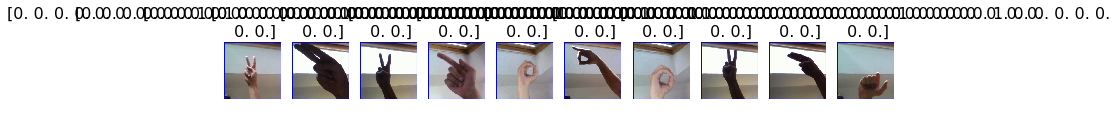

In [18]:
plots(imgs, titles=labels)

## Build Fine-tuned VGG16 model

In [19]:
vgg16_model = keras.applications.vgg16.VGG16()

Instructions for updating:
Colocations handled automatically by placer.


In [20]:
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [21]:
type(vgg16_model)

keras.engine.training.Model

In [22]:
vgg16_model.layers.pop()

In [23]:
# vgg16_model.outputs = [vgg16_model.layers[-6].output]
vgg16_model.layers[-1].outbound_nodes = []
#vgg16_model.add(Dense(26, activation='softmax'))

### converted keras.engine.training.Model type to Sequential

In [24]:
model = Sequential()
for layer in vgg16_model.layers:
    model.add(layer)

In [25]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)      

In [26]:
type(model)

keras.engine.sequential.Sequential

### keep all the weights of trained model as it is...dont change it

In [27]:
# for layer in model.layers[:-18]:
#     layer.trainable = False

In [28]:
model.add(Dense(26, activation='softmax'))

In [29]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)      

In [61]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

model.compile(Adam(lr=.0001), loss='categorical_crossentropy', metrics=['accuracy', f1_m, precision_m, recall_m])

In [31]:
# import tensorflow.compat.v1 as tf
# tf.disable_v2_behavior()

# config = tf.ConfigProto()
# config.gpu_options.allow_growth = True
# sess = tf.Session(config=config)

In [32]:
session = keras.backend.get_session()
init = tf.global_variables_initializer()
session.run(init)

In [33]:
from tensorflow.python.keras.backend import set_session
from tensorflow.python.keras.models import load_model
#tf_config = some_custom_config
config = tf.compat.v1.ConfigProto()
sess = tf.compat.v1.Session(config=config)
graph = tf.compat.v1.get_default_graph()

# IMPORTANT: models have to be loaded AFTER SETTING THE SESSION for keras! 
# Otherwise, their weights will be unavailable in the threads after the session there has been set
set_session(sess)

In [34]:
# import tensorflow as tf
# gpu_devices = tf.config.experimental.list_physical_devices('GPU')
# for device in gpu_devices: tf.config.experimental.set_memory_growth(device, True)

In [35]:
import tensorflow as tf
from tensorflow.compat.v1 import InteractiveSession
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [36]:
# physical_devices = tf.config.experimental.list_physical_devices('GPU')
# assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
# config = tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [37]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.5
sess = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config))

In [38]:
from tensorflow.python.keras.backend import set_session
from tensorflow.python.keras.models import load_model

tf_config = tf.compat.v1.ConfigProto()
sess = tf.Session(config=tf_config)
graph = tf.get_default_graph()

In [39]:
session = keras.backend.get_session()
init = tf.global_variables_initializer()
session.run(init)

In [40]:
# from __future__ import absolute_import, division, print_function, unicode_literals

# import tensorflow as tf
# print("Num GPUs Available: ", len(tf.compat.v1.config.experimental.list_physical_devices('GPU')))

In [41]:
model.fit_generator(train_batches, steps_per_epoch=100, validation_data=valid_batches, validation_steps=10, epochs=100, verbose=2)

Instructions for updating:
Use tf.cast instead.
Epoch 1/100
 - 52s - loss: 3.2903 - accuracy: 0.0400 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 3.2549 - val_accuracy: 0.0500 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 2/100
 - 48s - loss: 3.2411 - accuracy: 0.0500 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 3.0365 - val_accuracy: 0.0500 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 3/100
 - 48s - loss: 3.0263 - accuracy: 0.1250 - f1_m: 0.0293 - precision_m: 0.1217 - recall_m: 0.0170 - val_loss: 3.1701 - val_accuracy: 0.0500 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 4/100
 - 48s - loss: 2.7269 - accuracy: 0.1640 - f1_m: 0.0906 - precision_m: 0.3700 - recall_m: 0.0530 - val_loss: 2.2147 - val_accuracy: 0.1500 - val_f1_m: 0.1420 - val_precision_m: 0.4250 - val_recall_m: 0.0900
Epoch 5/100
 - 4

Epoch 37/100
 - 48s - loss: 0.2241 - accuracy: 0.9260 - f1_m: 0.9224 - precision_m: 0.9356 - recall_m: 0.9110 - val_loss: 0.1893 - val_accuracy: 0.9600 - val_f1_m: 0.9542 - val_precision_m: 0.9589 - val_recall_m: 0.9500
Epoch 38/100
 - 48s - loss: 0.1890 - accuracy: 0.9330 - f1_m: 0.9334 - precision_m: 0.9451 - recall_m: 0.9230 - val_loss: 0.0215 - val_accuracy: 0.9300 - val_f1_m: 0.9384 - val_precision_m: 0.9478 - val_recall_m: 0.9300
Epoch 39/100
 - 48s - loss: 0.1939 - accuracy: 0.9420 - f1_m: 0.9418 - precision_m: 0.9518 - recall_m: 0.9330 - val_loss: 0.0833 - val_accuracy: 0.9500 - val_f1_m: 0.9526 - val_precision_m: 0.9667 - val_recall_m: 0.9400
Epoch 40/100
 - 48s - loss: 0.1476 - accuracy: 0.9510 - f1_m: 0.9498 - precision_m: 0.9597 - recall_m: 0.9410 - val_loss: 0.0206 - val_accuracy: 0.9500 - val_f1_m: 0.9379 - val_precision_m: 0.9467 - val_recall_m: 0.9300
Epoch 41/100
 - 48s - loss: 0.1415 - accuracy: 0.9570 - f1_m: 0.9593 - precision_m: 0.9666 - recall_m: 0.9530 - val_loss

Epoch 75/100
 - 47s - loss: 0.0785 - accuracy: 0.9760 - f1_m: 0.9763 - precision_m: 0.9789 - recall_m: 0.9740 - val_loss: 0.0306 - val_accuracy: 0.9800 - val_f1_m: 0.9847 - val_precision_m: 0.9900 - val_recall_m: 0.9800
Epoch 76/100
 - 48s - loss: 0.0464 - accuracy: 0.9850 - f1_m: 0.9849 - precision_m: 0.9860 - recall_m: 0.9840 - val_loss: 1.3626e-04 - val_accuracy: 0.9900 - val_f1_m: 0.9900 - val_precision_m: 0.9900 - val_recall_m: 0.9900
Epoch 77/100
 - 47s - loss: 0.0920 - accuracy: 0.9730 - f1_m: 0.9746 - precision_m: 0.9787 - recall_m: 0.9710 - val_loss: 0.0130 - val_accuracy: 1.0000 - val_f1_m: 1.0000 - val_precision_m: 1.0000 - val_recall_m: 1.0000
Epoch 78/100
 - 48s - loss: 0.0460 - accuracy: 0.9870 - f1_m: 0.9879 - precision_m: 0.9890 - recall_m: 0.9870 - val_loss: 2.3962e-04 - val_accuracy: 0.9700 - val_f1_m: 0.9795 - val_precision_m: 0.9900 - val_recall_m: 0.9700
Epoch 79/100
 - 47s - loss: 0.0323 - accuracy: 0.9890 - f1_m: 0.9895 - precision_m: 0.9900 - recall_m: 0.9890 - 

In [42]:
model.save('A-to-Y-model.h5')

## Predict Sign language digits

In [19]:
from keras.models import load_model
from tensorflow.python.keras.backend import set_session

config = tf.compat.v1.ConfigProto()
sess = tf.compat.v1.Session(config=config)
vgg16_model = keras.applications.vgg16.VGG16()
vgg16_model.layers.pop()
# vgg16_model.outputs = [vgg16_model.layers[-6].output]
vgg16_model.layers[-1].outbound_nodes = []
model = Sequential()
for layer in vgg16_model.layers:
    model.add(layer)
for layer in model.layers[:-18]:
    layer.trainable = False
model.add(Dense(26, activation='softmax'))
set_session(sess)
model.load_weights('/home/dhanashree/MyFolder/Dev/atoz/digits_training/A-to-Y-model.h5')

Instructions for updating:
Colocations handled automatically by placer.


In [20]:
# scores = model.evaluate(X, Y, verbose=0)
# print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

In [21]:
test_labels = test_batches.classes

In [22]:
test_labels

array([ 0,  0,  0, ..., 25, 25, 25], dtype=int32)

In [23]:
test_batches.class_indices

{'A': 0,
 'B': 1,
 'C': 2,
 'D': 3,
 'E': 4,
 'F': 5,
 'G': 6,
 'H': 7,
 'I': 8,
 'K': 9,
 'L': 10,
 'M': 11,
 'N': 12,
 'O': 13,
 'P': 14,
 'Q': 15,
 'R': 16,
 'S': 17,
 'T': 18,
 'U': 19,
 'V': 20,
 'W': 21,
 'X': 22,
 'Y': 23,
 'del': 24,
 'space': 25}

In [24]:
predictions = model.predict_generator(test_batches, steps=780, verbose=0)

In [25]:
pre=predictions.argmax(axis=1)

In [26]:
pre

array([ 0,  0,  0, ..., 25, 25, 25])

## Visualize

In [34]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plot confusion matrix
    Normalization can be applied by setting 'normalize=True'
    """
    figure = plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks=np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
        
    print(cm)
    
    thresh = cm.max() / 2
    for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [35]:
cm = confusion_matrix(test_labels, pre,labels=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25])

Confusion matrix, without normalization
[[300   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0]
 [  3 283   0   1   0   0   0   0   6   0   0   0   0   0   0   0   0   0
    0   7   0   0   0   0   0   0]
 [  0   0 300   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0]
 [  0   0   0 300   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0]
 [  7   0   0   0 290   0   0   0   1   0   0   0   0   0   0   0   0   2
    0   0   0   0   0   0   0   0]
 [  0   0   0   0   0 300   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0 299   1   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   2   1 294   0   0   0   0   0   0   0   3   0   0
    0   0   0   0   0   0   0   0]
 [  0   0   0   8   0   0   0   0 292   0   0   0   0   0   0   0   0   0
    0   0   0 

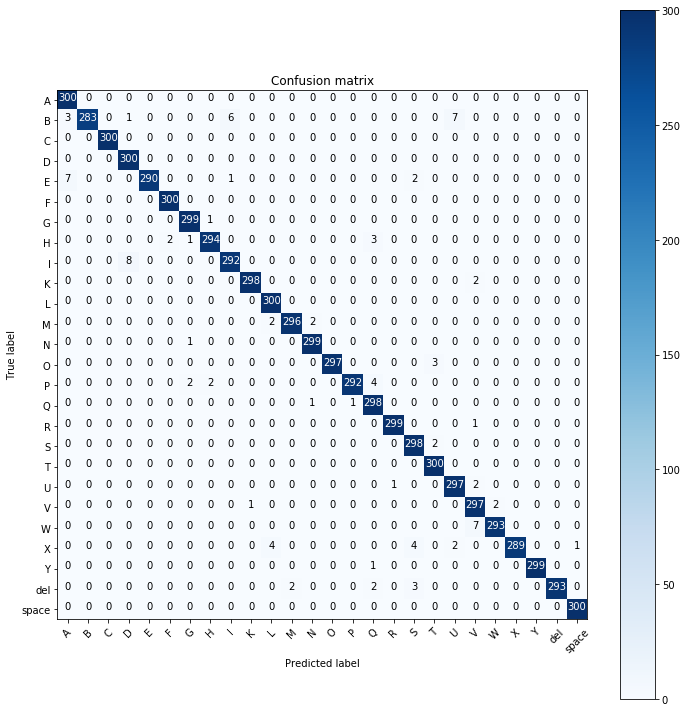

In [36]:
lbls=['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'del', 'space']
plot_confusion_matrix(cm,lbls,title='Confusion matrix')

In [62]:
model.evaluate(test_batches)

780/780 [==============================] - 119s 153ms/step


[0.0004808644880540669,
 0.9875640869140625,
 0.9875133037567139,
 0.9890849590301514,
 0.9861540198326111]

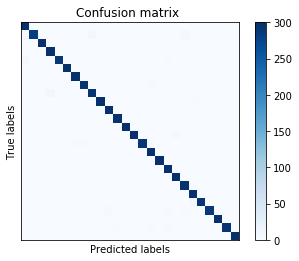

In [63]:
plt.imshow(cm, cmap=plt.cm.Blues)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.xticks([], [])
plt.yticks([], [])
plt.title('Confusion matrix ')
plt.colorbar()
plt.show()

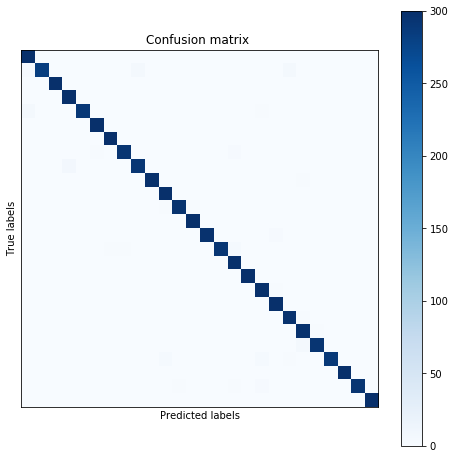

In [30]:
figure = plt.figure(figsize=(8, 8))
plt.imshow(cm, cmap=plt.cm.Blues)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.xticks([], [])
plt.yticks([], [])
plt.title('Confusion matrix ')
plt.colorbar()
plt.show()